In [2]:
import numpy as np
from random import random
from argparse import Namespace
import math
import matplotlib.pyplot as plt

In [3]:
def init_location(config):
    location = np.empty([config.population_size,2])
    for i in range(config.population_size):
        location[i,0] = config.x_low + random()*(config.x_high-config.x_low)
        location[i,1] = config.y_low + random()*(config.y_high-config.y_low)
    # check for x+y condition init
    for e in range(config.population_size):
        while location[e,0]+location[e,1] > config.x_y_BC:
            location[e,0] = config.x_low + random()*(config.x_high-config.x_low)
            location[e,1] = config.y_low + random()*(config.y_high-config.y_low)
    return location

In [4]:
def init_velocity(config):
    velocity = np.empty([config.population_size,2])
    for i in range(config.population_size):
        velocity[i,0] = -1 + random()*2
        velocity[i,1] = -1 + random()*2
    return velocity

In [5]:
def update_velocity(config,location,velocity,iteration,pbest,gbest,Craziness=False,k=0.5,c1=2,c2=2):
    w = 1-(iteration/config.max_iteration)*1
    x_range = config.x_high - config.x_low
    y_range = config.y_high - config.y_low
    v_max = k * np.array([x_range,y_range])
    for i in range(config.population_size):
        velocity[i] = w* velocity[i] + random()*c1*(pbest[i,:2]-location[i])+random()*c2*(gbest[:2]-location[i])
        # Craziness maintain diversity
        if Craziness and random() < config.p_crazy:
            velocity[i] = random()*v_max
        # check velocity for v_max
        for n,v in enumerate(velocity[i]):
            if v > v_max[n]:
                velocity[i,n] = ((velocity[i,n] / abs(velocity[i,n]))*v_max[n])
    return velocity

In [6]:
def ObjectiveFF(x,y):
    ff = math.exp(-0.1*(x**4 + y**4)) + math.exp(math.cos(2*math.pi*x) +math.cos(2*math.pi*y))
    return ff

In [7]:
def update_location(config,location,velocity):
    new_location = location + velocity
    # check for x , y location constraint
    # Bouncing strategy
    limit = np.array([[config.x_low,config.x_high],[config.y_low,config.y_high]])
    for i in range(config.population_size):
        for n,p in enumerate(new_location[i]):
            if p < limit[n,0] or p > limit[n,1]:
                new_location[i,n] = location[i,n]
    return new_location 

In [8]:
def penalty(x,y,constraint):
    if x + y <= constraint:
        return 0

    value = x + y - constraint
    const = 2 if value < 0.5 else 4
    return const*value**2

In [9]:
def update_pbest(location,function,pbest):
    for i in range(config.population_size):
        x,y = location[i] 
        fitness = function(x,y) - penalty(x,y,config.x_y_BC)
        if fitness > pbest[i][2]:
            pbest[i,:2] = location[i]
            pbest[i][2] = fitness
    return pbest

In [36]:
# define parameters
config= Namespace(
    population_size = 40,
    # x constraint
    x_high = 1,
    x_low = -1,
    # y constraint
    y_high = 1,
    y_low = -2,
    # x+y constraint
    x_y_BC = 1,

    p_crazy = 0.15,
    max_iteration = 200,
)

first gbest solution 8.080 at (0.009,0.046)
------------
Start optimization..
best solution 8.33810 at (-0.01,-0.02) in   6 iteration
best solution 8.35283 at ( 0.01,-0.01) in  48 iteration
best solution 8.36681 at ( 0.00,-0.01) in  52 iteration
best solution 8.37517 at ( 0.00,-0.01) in  78 iteration
best solution 8.38752 at (-0.00, 0.00) in  88 iteration
best solution 8.38803 at (-0.00,-0.00) in  97 iteration
best solution 8.38840 at (-0.00, 0.00) in 103 iteration
best solution 8.38872 at (-0.00, 0.00) in 107 iteration
best solution 8.38884 at (-0.00, 0.00) in 110 iteration
best solution 8.38885 at (-0.00,-0.00) in 142 iteration
best solution 8.38899 at (-0.00, 0.00) in 150 iteration
best solution 8.38904 at (-0.00,-0.00) in 158 iteration
best solution 8.38905 at (-0.00,-0.00) in 159 iteration
best solution 8.38905 at (-0.00,-0.00) in 160 iteration
best solution 8.38905 at (-0.00,-0.00) in 161 iteration
best solution 8.38905 at (-0.00,-0.00) in 162 iteration
best solution 8.38905 at (

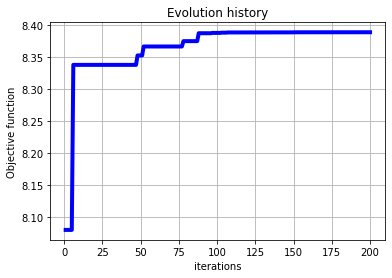

In [37]:
# main code

# init location and velovity
location = init_location(config)
velocity = init_velocity(config)
# init pbest and gbest
pbest = np.empty([config.population_size,3])
pbest[:,:2] = location
pbest[:,2] = np.array([ObjectiveFF(x,y) for x,y in location])
idx = np.argmax(pbest[:,2])
gbest = pbest[idx]
best_record = []
iter_record=[]
print('first gbest solution {:.3f} at ({:.3f},{:.3f})'.format(gbest[2],gbest[0],gbest[1]))
best_solution = gbest[2]
# start optimization
iteration = 0
print('------------')
print('Start optimization..')
while iteration < config.max_iteration:

    velocity = update_velocity(config,location,velocity,iteration+1,pbest,gbest,Craziness = True)

    location = update_location(config,location,velocity)

    pbest = update_pbest(location,ObjectiveFF,pbest)

    for i in range(config.population_size):
        if pbest[i,2] > gbest[2]:
            gbest[:2] = pbest[i,:2]
            gbest[2] = pbest[i,2]

    if gbest[2] > best_solution:
        best_solution = gbest[2]
        print('best solution {:.5f} at ({:5.2f},{:5.2f}) in {:3} iteration'.format(gbest[2],gbest[0],gbest[1],iteration+1))

    iter_record.append(iteration+1)
    best_record.append(best_solution)

    iteration +=1
else:
    print('End of iteration')
    print('--------------')

# Plot evolution history
plt.plot(iter_record,best_record,'b-',linewidth=4)
plt.xlabel('iterations')
plt.ylabel('Objective function')
plt.title('Evolution history')
plt.grid(True)